# Final project COGS 118B


## Part 1: Data


In [16]:
#from google.colab import files
import io
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing 
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt

In [17]:
# Upload data
#uploaded = files.upload()

In [18]:
# Convert the data into Pandas dataframe
#df = pd.read_csv(io.BytesIO(uploaded['Country-data.csv']))
df = pd.read_csv ('Country-data.csv')
df.head()
# Dataset is now stored in a Pandas Dataframe

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Part 2: K-means clustering

### 2.1 Without scaling the features

In [19]:
# Convert the data into numpy array
dfArray = df.to_numpy()

In [20]:
# Look at data
dfArray.shape # data shape 167x10
dfArray[0:,:] # columns are: Name, child_mort, exports, health, imports, income, inflation, life_expec, total_fer, gdpp.

array([['Afghanistan', 90.2, 10.0, ..., 56.2, 5.82, 553],
       ['Albania', 16.6, 28.0, ..., 76.3, 1.65, 4090],
       ['Algeria', 27.3, 38.4, ..., 76.5, 2.89, 4460],
       ...,
       ['Vietnam', 23.3, 72.0, ..., 73.1, 1.95, 1310],
       ['Yemen', 56.3, 30.0, ..., 67.5, 4.67, 1310],
       ['Zambia', 83.1, 37.0, ..., 52.0, 5.4, 1460]], dtype=object)

In [21]:
# Remove first column with the country names 
dfArray_Values = dfArray[:,1:]

# Print shape 
print(dfArray_Values.shape)

# Look at the first rows - check 
dfArray_Values[0:10,:]

(167, 9)


array([[90.2, 10.0, 7.58, 44.9, 1610, 9.44, 56.2, 5.82, 553],
       [16.6, 28.0, 6.55, 48.6, 9930, 4.49, 76.3, 1.65, 4090],
       [27.3, 38.4, 4.17, 31.4, 12900, 16.1, 76.5, 2.89, 4460],
       [119.0, 62.3, 2.85, 42.9, 5900, 22.4, 60.1, 6.16, 3530],
       [10.3, 45.5, 6.03, 58.9, 19100, 1.44, 76.8, 2.13, 12200],
       [14.5, 18.9, 8.1, 16.0, 18700, 20.9, 75.8, 2.37, 10300],
       [18.1, 20.8, 4.4, 45.3, 6700, 7.77, 73.3, 1.69, 3220],
       [4.8, 19.8, 8.73, 20.9, 41400, 1.16, 82.0, 1.93, 51900],
       [4.3, 51.3, 11.0, 47.8, 43200, 0.873, 80.5, 1.44, 46900],
       [39.2, 54.3, 5.88, 20.7, 16000, 13.8, 69.1, 1.92, 5840]],
      dtype=object)

In [22]:
# Convert datapoints to float 
dfArray_Values = np.array(list(dfArray_Values), dtype=float)
dfArray_Values

array([[9.02e+01, 1.00e+01, 7.58e+00, ..., 5.62e+01, 5.82e+00, 5.53e+02],
       [1.66e+01, 2.80e+01, 6.55e+00, ..., 7.63e+01, 1.65e+00, 4.09e+03],
       [2.73e+01, 3.84e+01, 4.17e+00, ..., 7.65e+01, 2.89e+00, 4.46e+03],
       ...,
       [2.33e+01, 7.20e+01, 6.84e+00, ..., 7.31e+01, 1.95e+00, 1.31e+03],
       [5.63e+01, 3.00e+01, 5.18e+00, ..., 6.75e+01, 4.67e+00, 1.31e+03],
       [8.31e+01, 3.70e+01, 5.89e+00, ..., 5.20e+01, 5.40e+00, 1.46e+03]])

In [23]:
def calcSqDistances(X, Kmus):
  sqDist = ((-2 * X.dot(Kmus.T) + np.sum(np.multiply(Kmus,Kmus), axis = 1).T).T + np.sum(np.multiply(X,X), axis = 1)).T
  return sqDist

In [24]:
def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis = 1)
    Rnk = np.eye(sqDmat.shape[1])[m]
    return Rnk

In [25]:
def recalcMus(X, Rnk):
    N,D = X.shape 
    Kmus_new = (np.divide(X.T.dot(Rnk),np.sum(Rnk,axis = 0))).T
    
    return Kmus_new

In [26]:
def runKMeans(K, data):
    X = data
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        sqDmat = calcSqDistances(X, Kmus)
        Rnk = determineRnk(sqDmat)
        KmusOld = Kmus
        
        Kmus = recalcMus(X, Rnk)
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-12:
            print('Number of iterations running K-means: ', iter)
            break

    return Rnk

In [76]:
def displayCluster(string,cluster_locations, dfArray, file_name_svg): # WORLD MAP FUNCTION

    import pandas as pd
    countries_ab = pd.read_csv('countries_ab.csv')
   # countries_ab
    countries_ab_new = countries_ab.to_numpy()
    

    characters0 = []
# Iterate over a sequence of numbers from 0 to 4
    for i in range(np.size(cluster_locations,axis =1)):
    # In each iteration, add an empty list to the main list
        characters0.append([])
    

    for i in range(len(dfArray[:,0])):
        for j in range(np.size(cluster_locations, axis = 1)):
            if cluster_locations[i,j] ==1:
                characters0[j].append((dfArray[i,0]))

#print(countries_ab_new[:,0])

    # THESE ARE THE CHARACTER CODES FOR EACH CLUSTER NAMES
    cluster_new = []
# Iterate over a sequence of numbers from 0 to 4
    for i in range(np.size(cluster_locations,axis =1)):
    # In each iteration, add an empty list to the main list
        cluster_new.append([])
    
#print(cluster_new)

    for i in range(len(countries_ab_new[:,0])):
        for j in range(np.size(cluster_locations, axis = 1)):
            if countries_ab_new[i,1] in characters0[j]:
                cluster_new[j].append(countries_ab_new[i,0])
     

    

    import pygal


#import Style class from pygal.style
    from pygal.style import Style

         #create a Style object
    custom_style = Style( colors = ('#FF0000' , '#0000FF' ,'#00FF00' , '#000000'))

    # the custom colours in the map,
    worldmap = pygal.maps.world.World(style = custom_style)

    # set the title of the map
    worldmap.title = string

    for i in range(np.size(cluster_locations, axis = 1)):
        worldmap.add('Cluster: %i'%(i + 1) , cluster_new[i]) # CHARACTER CODES FROM BEFORE

    # save into the file
    worldmap.render_to_file(file_name_svg)

    print("Success")

In [ ]:
cluster_locations = runKMeans(3, dfArray_Values)

displayCluster("Countries without scaling",cluster_locations, dfArray,'countries_without_scaling.svg' )
from IPython.core.display import SVG
SVG(filename='countries_without_scaling.svg')

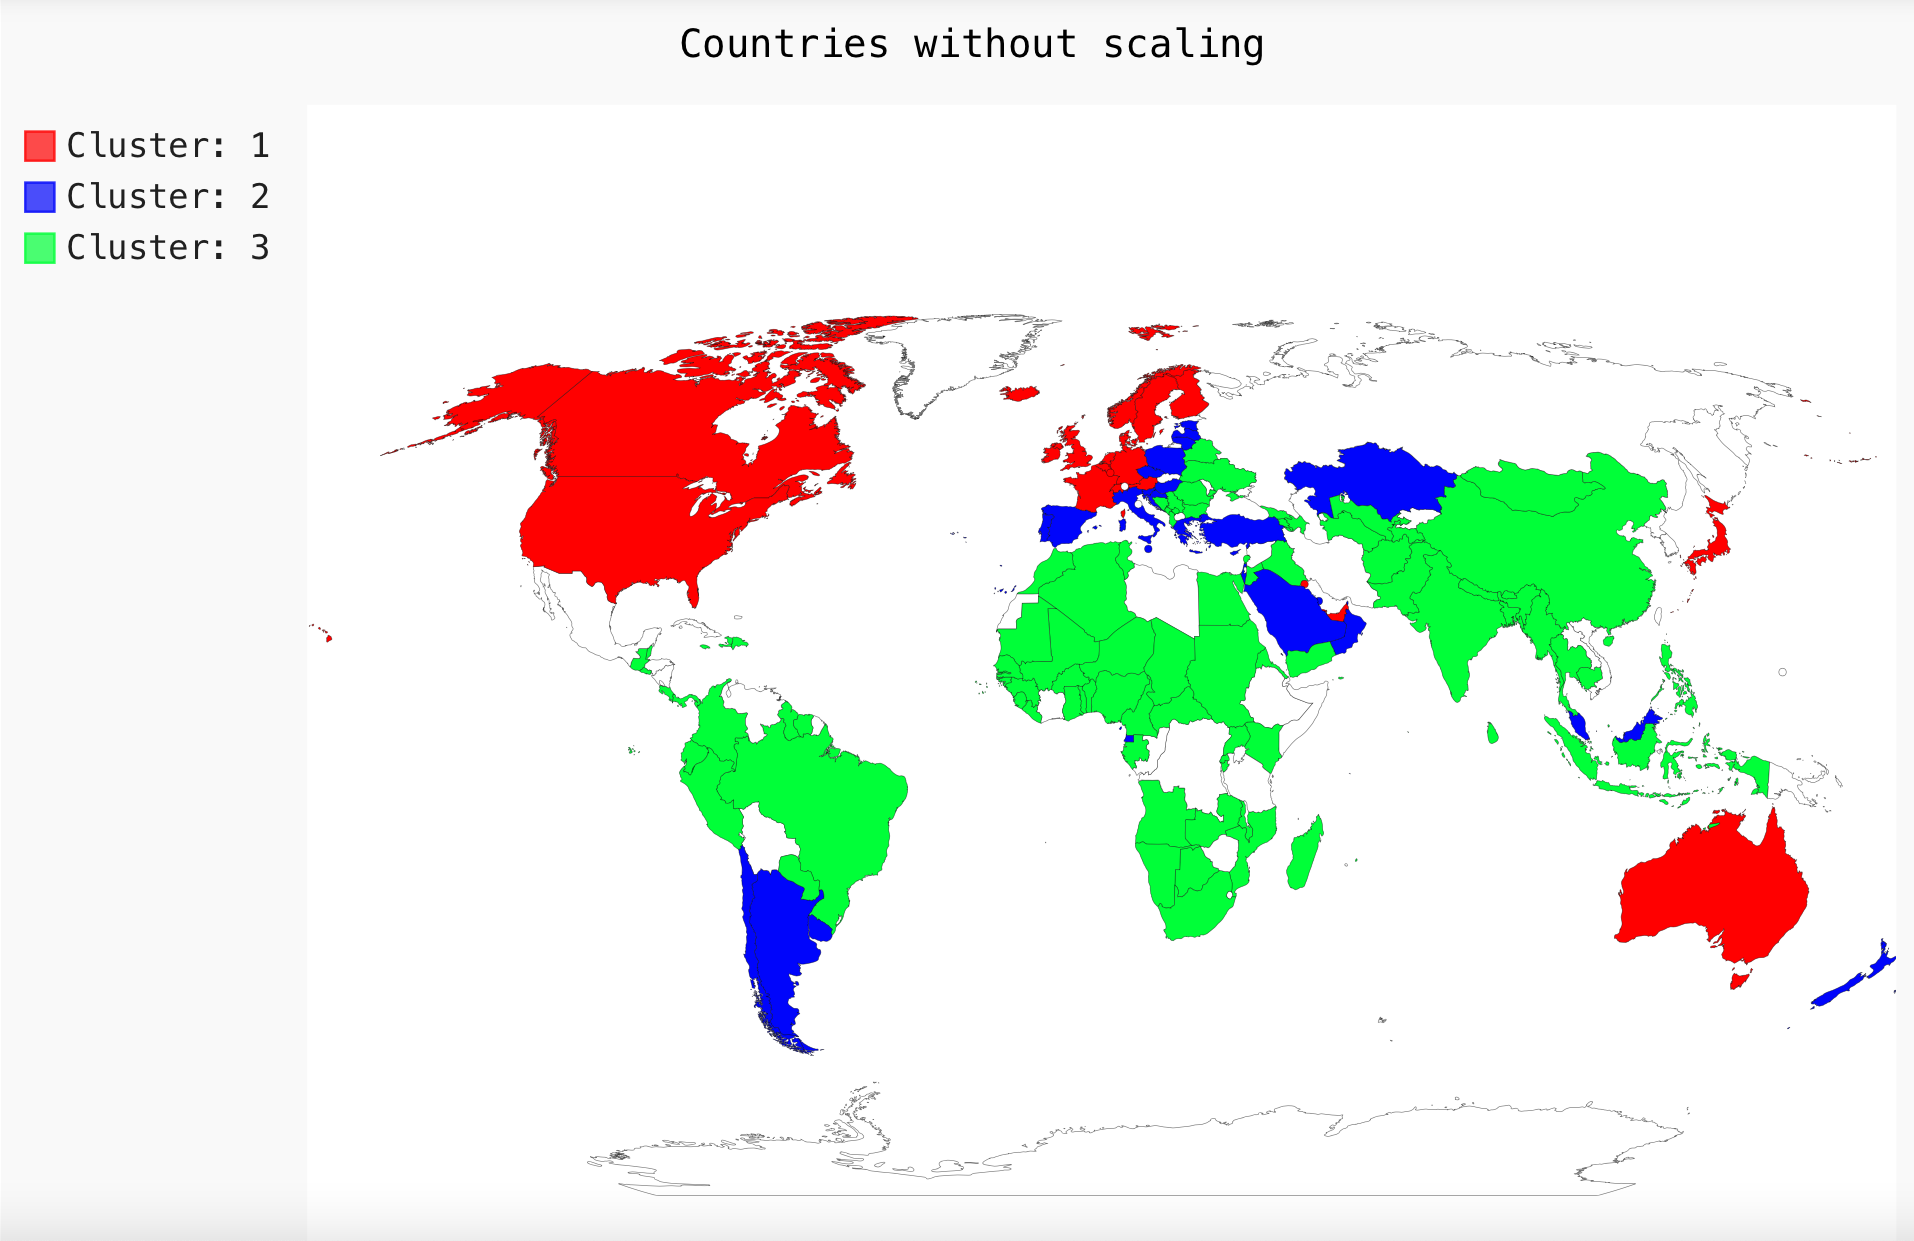

In [30]:
# Plotting

# Create empty matrix 
n,k = cluster_locations.shape
cluster_index = np.zeros((n), dtype = np.int32)

# Create cluster matrix 
for i in range(len(cluster_locations)):
  for cluster in range(k):
    if cluster_locations[i,cluster] == 1:
      cluster_index[i]=cluster

In [31]:
# Add cluster column
df_WithCluster = df.copy()
df_WithCluster['clusters']= cluster_index


### 2.2 With scaling

In [55]:
# We drop the labels in the pandas dataframe too
df2 = df.drop('country', axis=1)
df2.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [56]:
# Standard scale the data to avoid features with large values having large impact
# numpy array
dfArray_Normal = preprocessing.scale(df2)

# Transforming normalized data into panda dataframe: Used for plotting
# panda dataframe
df_Normalized = pd.DataFrame(dfArray_Normal,columns= df2.columns)


In [ ]:
# Run K-means on scaled data
cluster_LocNormal = runKMeans(3, dfArray_Normal)
displayCluster("Countries after scaling",cluster_LocNormal, dfArray, 'countries_after_scaling.svg')
from IPython.core.display import SVG
SVG(filename='countries_after_scaling.svg')

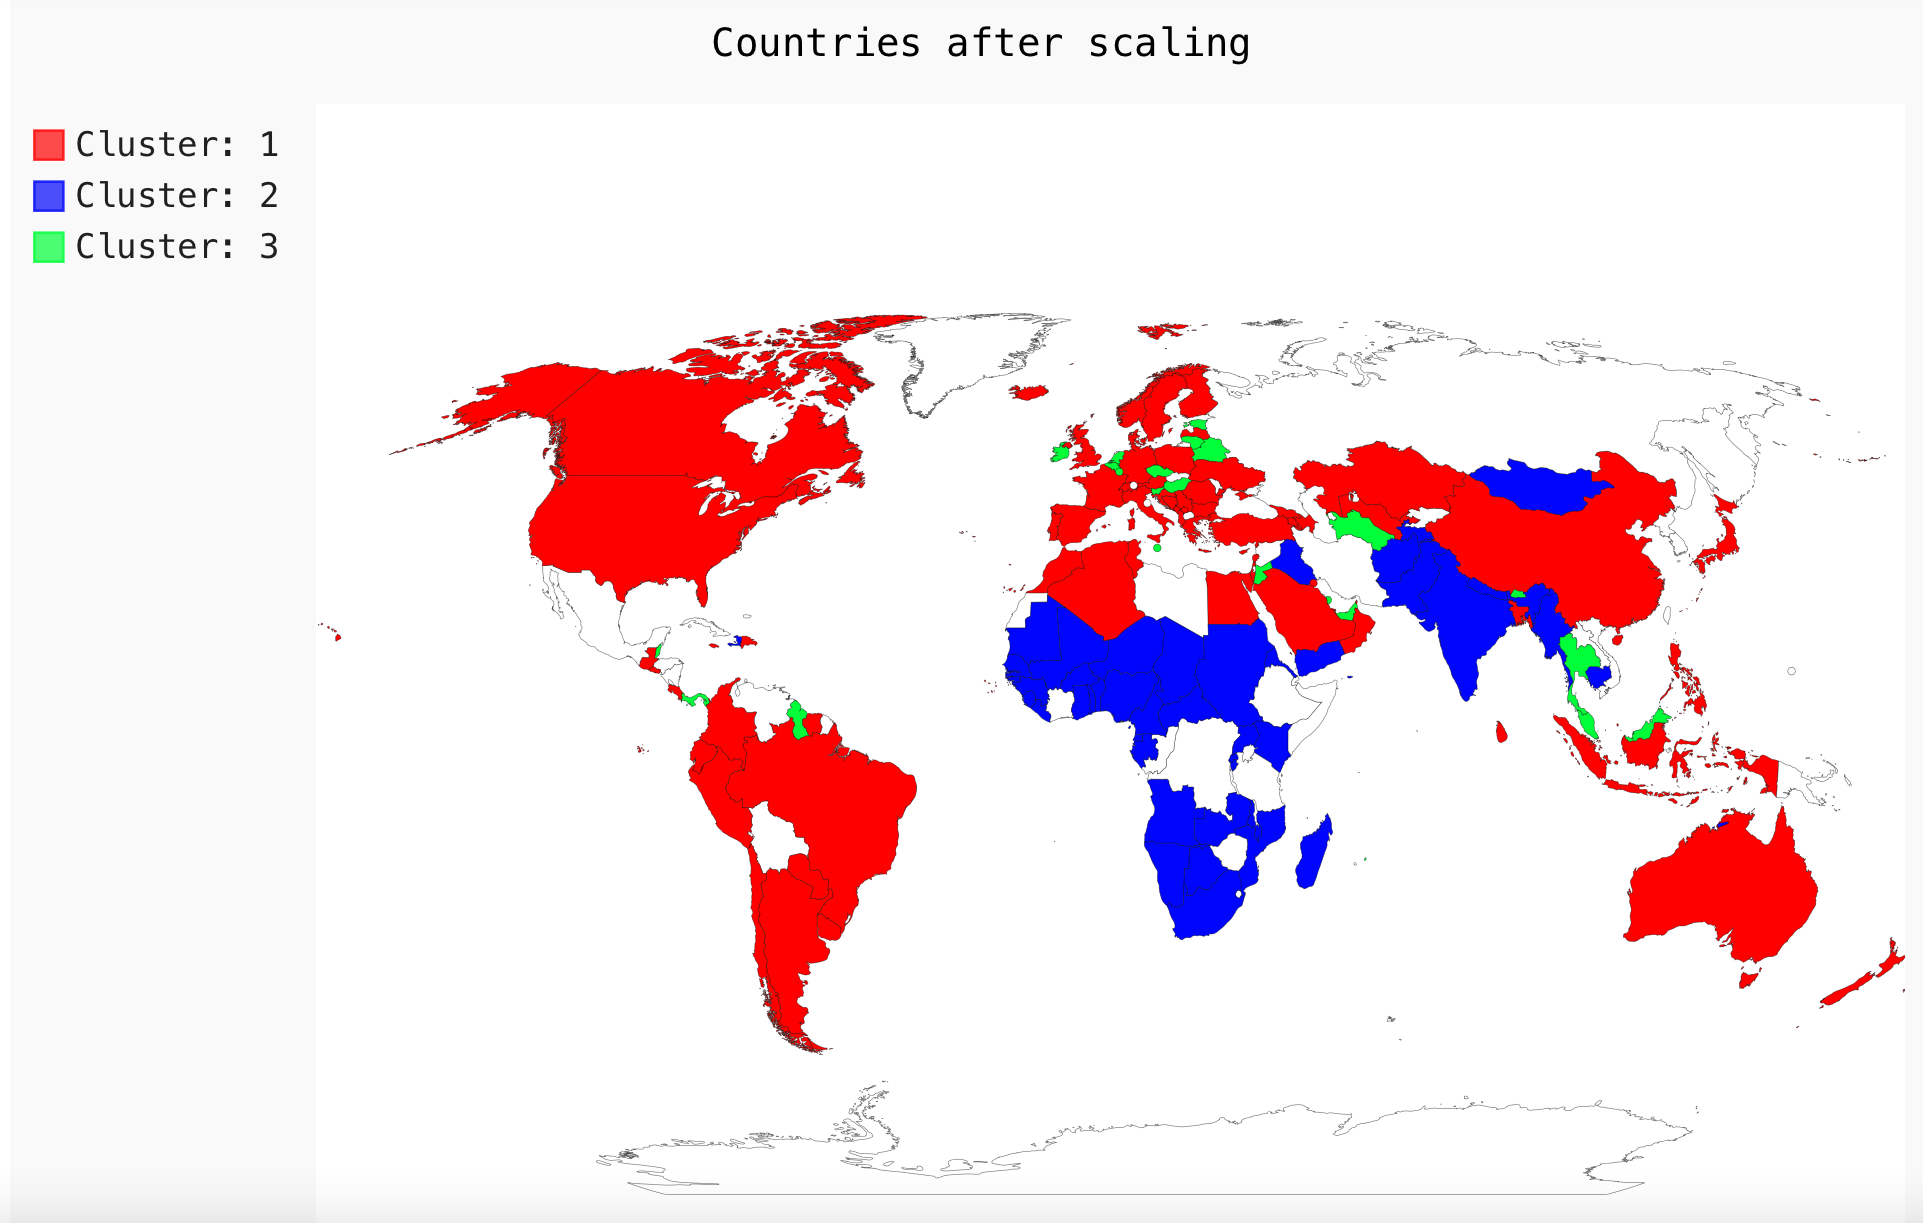

In [94]:
# Create empty matrix 
n,k = cluster_LocNormal.shape
cluster_IndNormal = np.zeros((n), dtype = np.int32)

# Create cluster matrix 
for i in range(len(cluster_LocNormal)):
  for cluster in range(k):
    if cluster_LocNormal[i,cluster] == 1:
      cluster_IndNormal[i]=cluster

In [96]:
# Add cluster column
df_Normalized['clusters']= cluster_IndNormal + 1
df_Normalized

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,2
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,1
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,1
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,2
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,1
...,...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913,2
163,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323,1
164,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754,3
165,0.448417,-0.406478,-0.597272,-0.517472,-0.658924,1.500916,-0.344633,1.140944,-0.637754,2


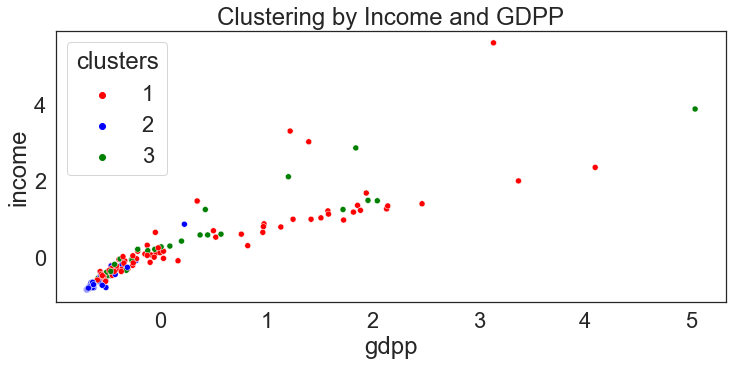

In [98]:
# Plot
# after scaling
sns.scatterplot(x= 'gdpp', y='income', hue='clusters', 
                data=df_Normalized, palette=['red','blue','green']).set(title='Clustering by Income and GDPP')

[Text(0.5, 1.0, 'Clustering by Health and GDPP')]

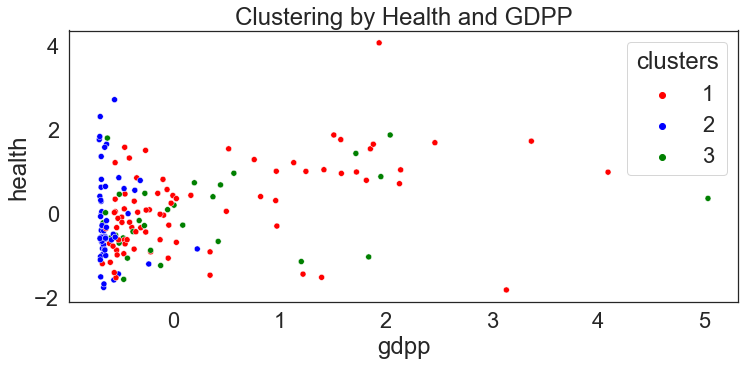

In [100]:
# Gdpp, health
sns.scatterplot(x= 'gdpp', y='health', hue='clusters', 
                data=df_Normalized, palette=['red','blue','green']).set(title='Clustering by Health and GDPP')

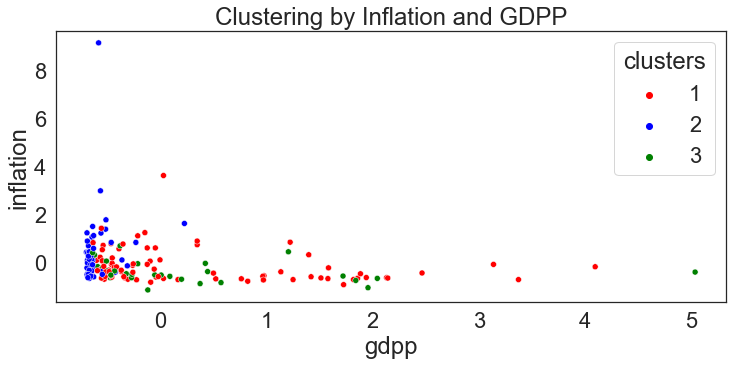

In [101]:
# Gdpp, inflation

sns.scatterplot(x= 'gdpp', y='inflation', hue='clusters', 
                data=df_Normalized, palette=['red','blue','green']).set(title='Clustering by Inflation and GDPP')

[Text(0.5, 1.0, 'Clustering by Exports and Imports')]

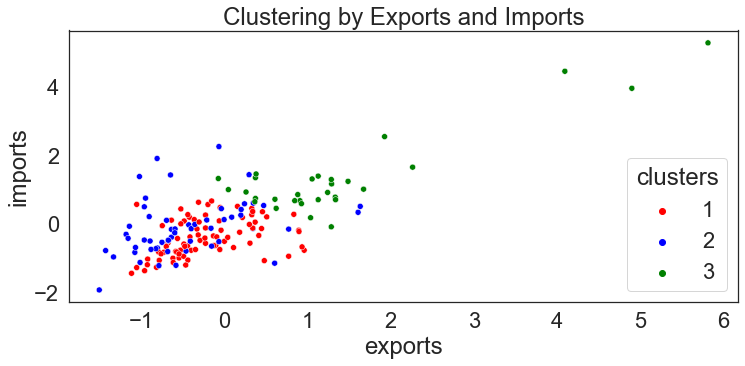

In [102]:
sns.scatterplot(x= 'exports', y='imports', hue='clusters', 
                data=df_Normalized, palette=['red','blue','green']).set(title='Clustering by Exports and Imports')


[Text(0.5, 1.0, 'Clustering by Life Expectancy and Health')]

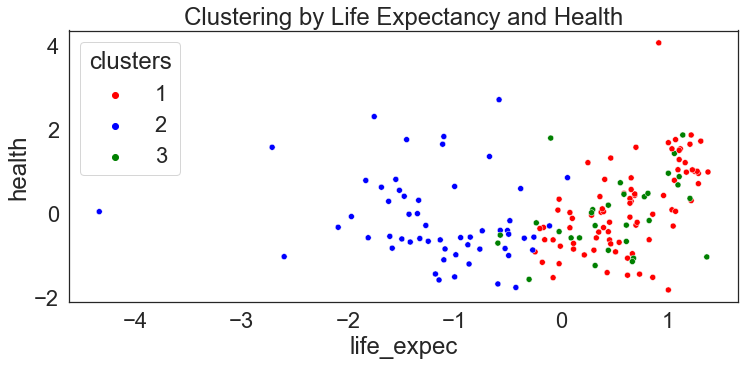

In [103]:
sns.scatterplot(x= 'life_expec', y='health', hue='clusters', 
                data=df_Normalized, palette=['red','blue','green']).set(title='Clustering by Life Expectancy and Health')



## Part C: PCA

In [104]:
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


### Number of dimensions needed

In [70]:
df2.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


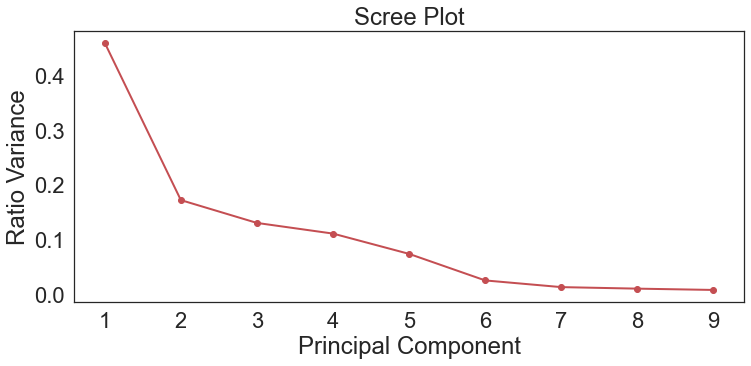

In [84]:
# We used the scaled data
# Plotting variance Ratio - Used for optimal number of dimensions 
# reduced_data1=PCA(n_components=9).fit(dfArray_Normal)

# explained_variance = np.cumsum(np.round(reduced_data1.explained_variance_ratio_, decimals=5)*100)

# # Scree Plot
# plt.plot(explained_variance, marker='x', color = 'blue')
# plt.title('Scree Plot: PCs and their Cumulative Explained Variance Ratio',fontsize=15)
# plt.xlabel('Number of components',fontsize=12)
# plt.ylabel('Cumulative Explained Variance Ratio',fontsize=12)


pca=PCA(n_components=9).fit(dfArray_Normal)
PC_values = np.arange(pca.n_components) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Ratio Variance')
plt.show()

### PCA to reduce dimensions

In [ ]:
# Run PCA -> reduces dimensions
pca = PCA(n_components = 5)

principalComp = pca.fit_transform(dfArray_Normal)
principalDf = pd.DataFrame(data = principalComp)
             #, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
principalDfNP = principalDf.to_numpy()
#principalDfNP
cluster_LocPCA = runKMeans(3, principalDfNP)

displayCluster("5 components PCA clustering",cluster_LocPCA, dfArray, 'PCA_clusters.svg')
from IPython.core.display import SVG
SVG(filename='PCA_clusters.svg')


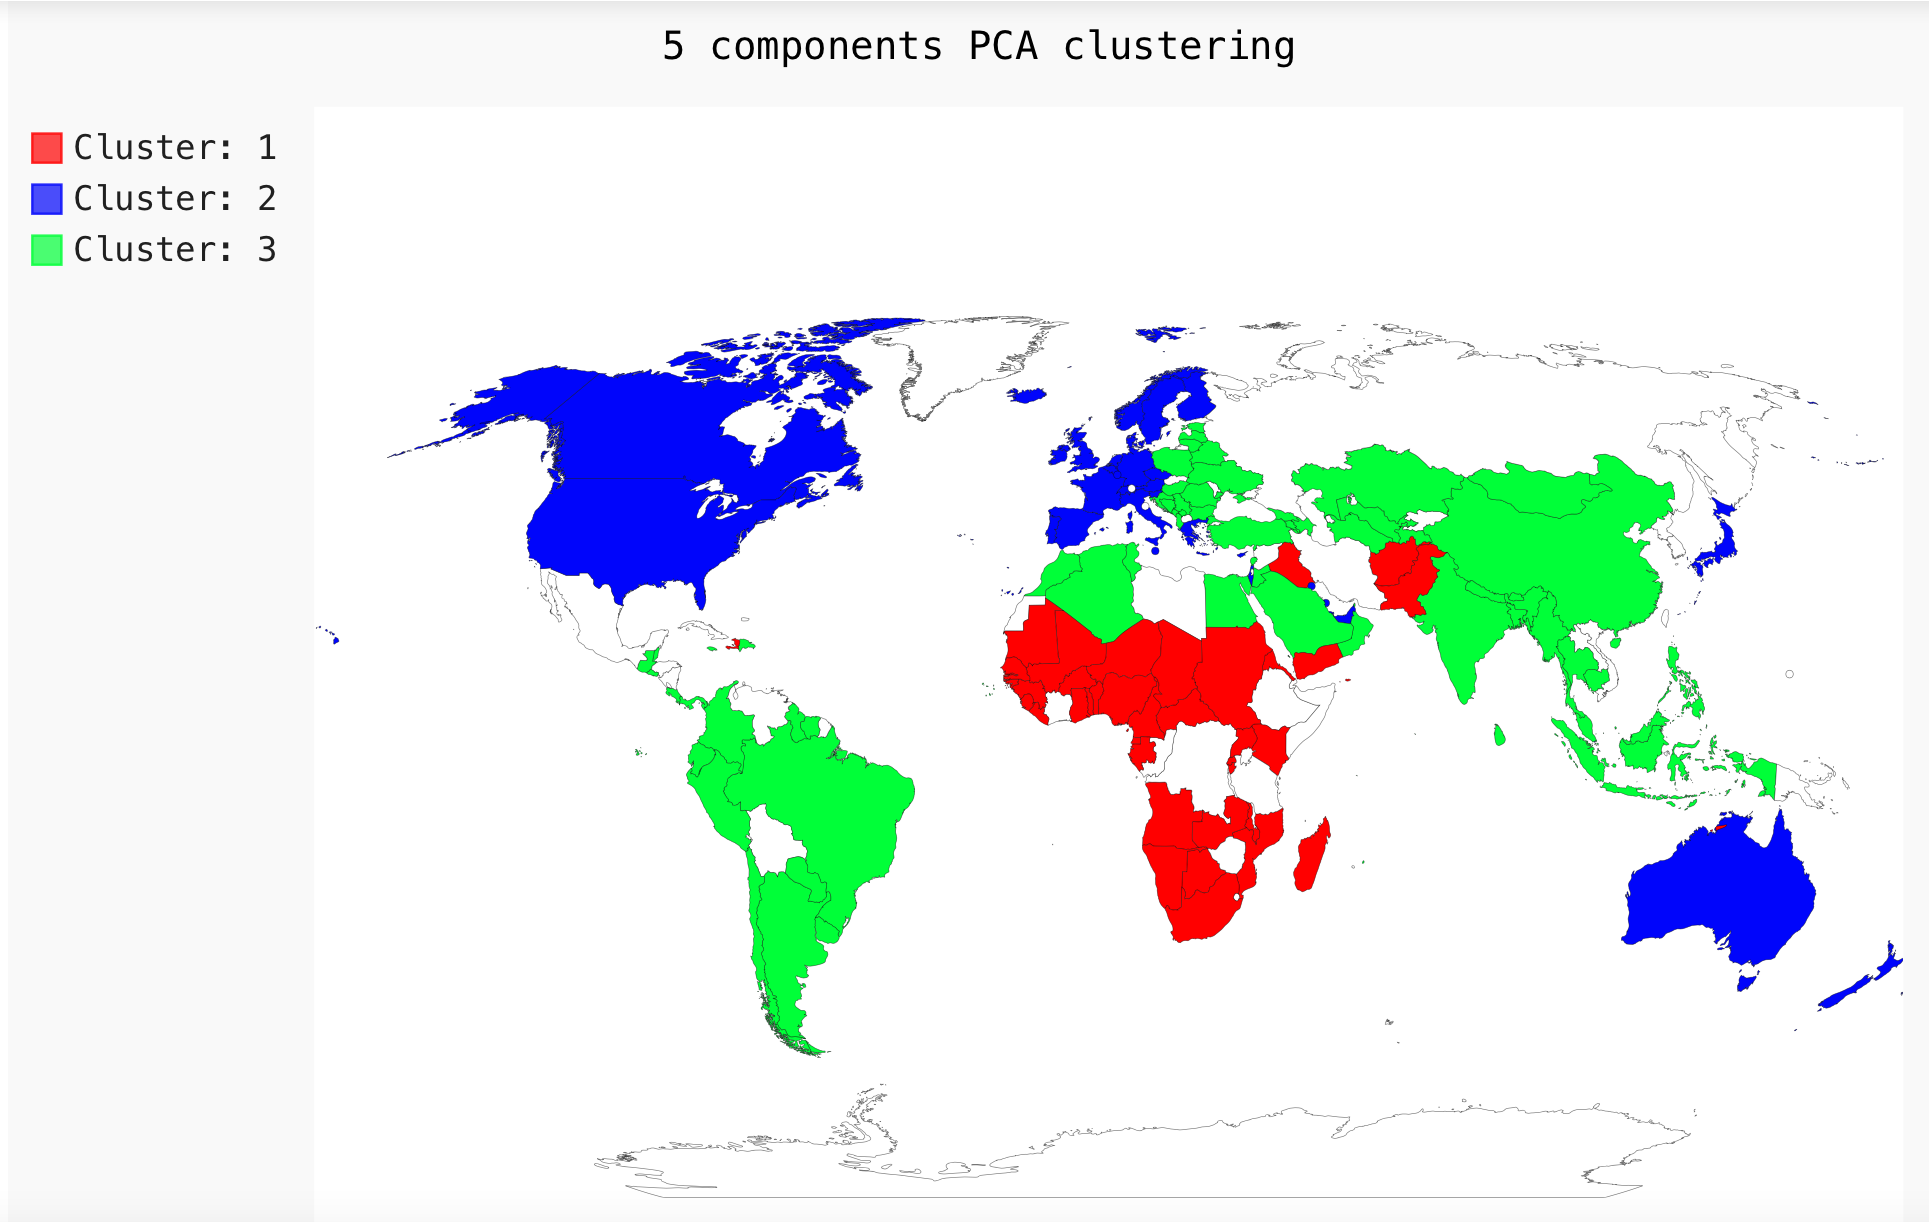